In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import normalized_mutual_info_score

In [18]:
df = pd.read_csv("birds2025.csv", sep=';')

def minmax_scaling(df, features=['length', 'wspan', 'weight', 'AR', 'wload']):
    minmax_df = df.copy()
    for feature in features:
        column = minmax_df[feature]
        min_val = column.min()
        max_val = column.max()
        minmax_df[feature] = (column - min_val) / (max_val - min_val)
    return minmax_df
                                       
def mean_scaling(df, features=['length', 'wspan', 'weight', 'AR', 'wload']):
    scaled_df = df.copy()
    for feature in features:
        col = scaled_df[feature]
        scaled_df[feature] = (col - col.min()) / (col.max() - col.min())
    return scaled_df

def midpoint(value):
        if isinstance(value, str) and '-' in value:
            try:
                a, b = map(float, value.split('-'))
                return (a + b) / 2
            except ValueError:
                return value
        try:
            return float(value)
        except ValueError:
            return value

def midpoint_column(df, features=['length', 'wspan', 'weight']):
    df_mid = df.copy()
    for feature in features:
        df_mid[feature] = df_mid[feature].apply(midpoint)
    return df_mid

def add_bmi(df):
    """
    Adds a new column 'bmi' = weight / length^2
    """
    new_df = df.copy()
    new_df['bmi'] = new_df["weight"] / (new_df["length"] ** 2)
    return new_df


def add_wsi(df):
    """
    Adds a new column 'wsi' = wspan / length
    """
    new_df = df.copy()
    new_df['wsi'] = new_df["wspan"] / new_df["length"]
    return new_df

def pwnum_dists(df, features=['length', 'wspan', 'weight', 'AR', 'wload']):
    
    X = df[features].to_numpy()
    dist_vector = pdist(X, metric='euclidean')
    return squareform(dist_vector)

    
df = midpoint_column(df)
df = add_bmi(df)
df = add_wsi(df)
df_minmax = minmax_scaling(df)
df_meanscaled = mean_scaling(df)
dists1 = pwnum_dists(df_meanscaled, ['length', 'wspan', 'weight', 'AR', 'wload', 'bmi', 'wsi'])
dists2 = pwnum_dists(df_minmax, ['length', 'wspan', 'weight', 'AR', 'wload', 'bmi', 'wsi'])
print(dists1)
print(dists2)

[[0.         0.46136074 0.52572466 ... 0.61584104 0.38196088 1.20580667]
 [0.46136074 0.         0.09036519 ... 0.58542806 0.51427859 0.99084393]
 [0.52572466 0.09036519 0.         ... 0.62500939 0.52632661 0.92971703]
 ...
 [0.61584104 0.58542806 0.62500939 ... 0.         0.58699039 0.98356373]
 [0.38196088 0.51427859 0.52632661 ... 0.58699039 0.         0.92311355]
 [1.20580667 0.99084393 0.92971703 ... 0.98356373 0.92311355 0.        ]]
[[0.         0.46136074 0.52572466 ... 0.61584104 0.38196088 1.20580667]
 [0.46136074 0.         0.09036519 ... 0.58542806 0.51427859 0.99084393]
 [0.52572466 0.09036519 0.         ... 0.62500939 0.52632661 0.92971703]
 ...
 [0.61584104 0.58542806 0.62500939 ... 0.         0.58699039 0.98356373]
 [0.38196088 0.51427859 0.52632661 ... 0.58699039 0.         0.92311355]
 [1.20580667 0.99084393 0.92971703 ... 0.98356373 0.92311355 0.        ]]


In [124]:
def main_colour(c):
    try:
        pre , main  = c.split(' ')
    except ValueError:
        main = c
    return main


def col_distance(c1, c2):
    if c1 == c2:
        return 0.0
    m1, m2 = main_colour(c1), main_colour(c2)
    if m1 == m2:
        return 0.8  #0.9 - 0.7 seems to have best results
    return 1

def ftype_distance(f1, f2):
    if f1 == f2:
        return 0.0
    return 1

def cat_dists(df, feature, func):
    n = len(df)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = func(df.iloc[i][feature], df.iloc[j][feature])
            mat[i, j] = mat[j, i] = d
    return mat



In [146]:
back_dists = cat_dists(df, 'back', col_distance)
belly_dists = cat_dists(df, 'belly', col_distance)
ftype_dists = cat_dists(df, 'ftype', ftype_distance)
dists_cat = (back_dists+ belly_dists+ftype_dists)/3
print(dists_cat)
combined_dists = (dists1 * 1 + dists_cat * 1)/2
print(combined_dists)

[[0.         0.26666667 0.26666667 ... 1.         1.         1.        ]
 [0.26666667 0.         0.         ... 1.         1.         1.        ]
 [0.26666667 0.         0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         0.6        0.33333333]
 [1.         1.         1.         ... 0.6        0.         0.53333333]
 [1.         1.         1.         ... 0.33333333 0.53333333 0.        ]]
[[0.         0.3640137  0.39619566 ... 0.80792052 0.69098044 1.10290334]
 [0.3640137  0.         0.0451826  ... 0.79271403 0.7571393  0.99542197]
 [0.39619566 0.0451826  0.         ... 0.81250469 0.7631633  0.96485851]
 ...
 [0.80792052 0.79271403 0.81250469 ... 0.         0.59349519 0.65844853]
 [0.69098044 0.7571393  0.7631633  ... 0.59349519 0.         0.72822344]
 [1.10290334 0.99542197 0.96485851 ... 0.65844853 0.72822344 0.        ]]


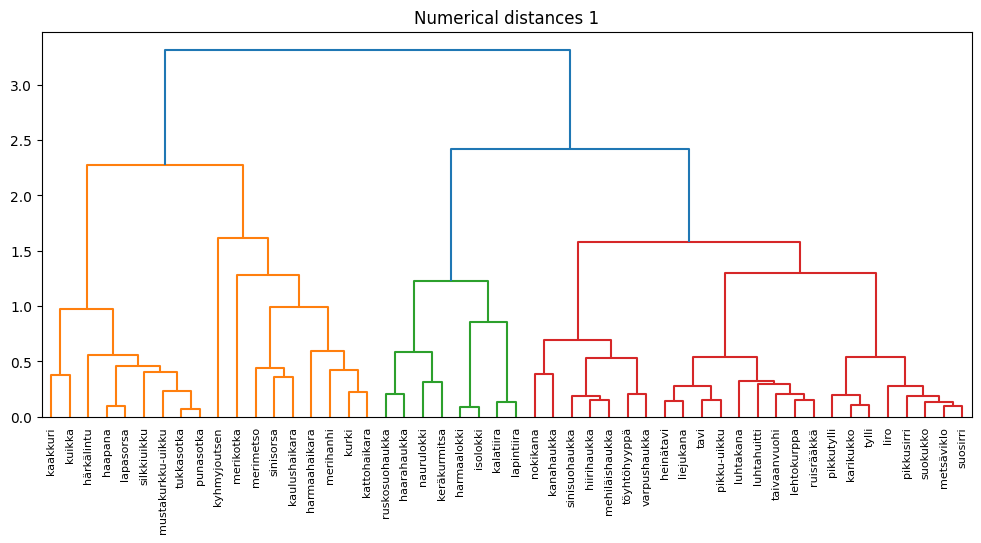

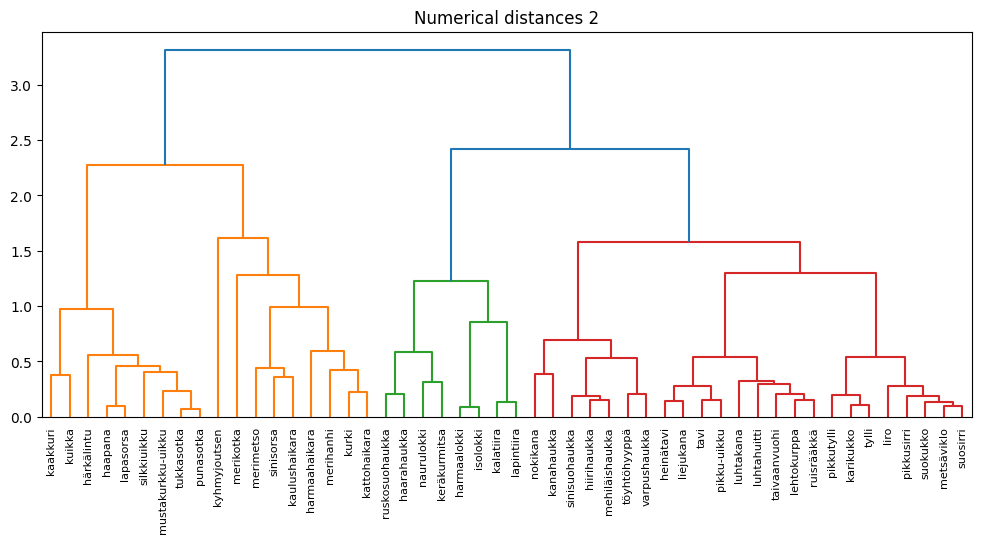

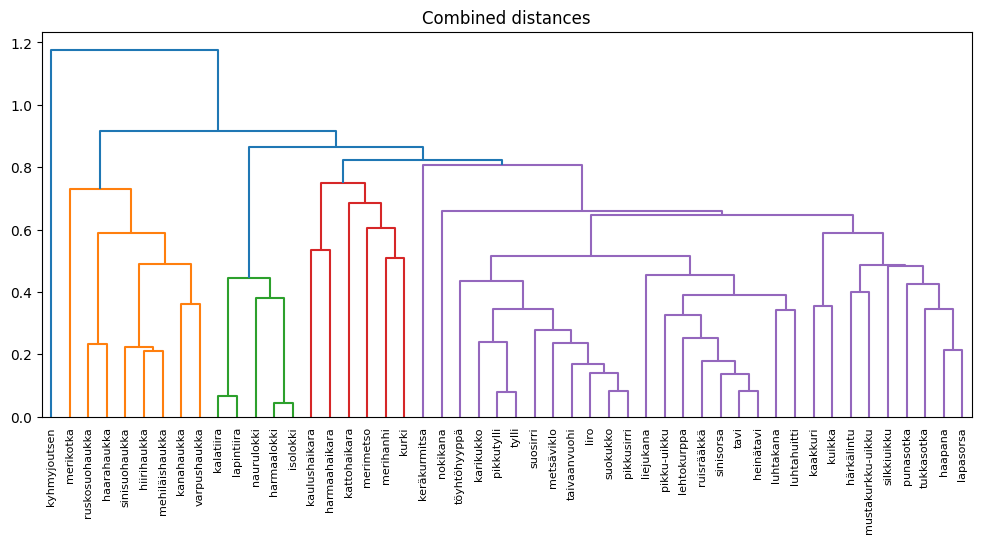

In [147]:

Z_num1 = linkage(squareform(dists1), method='ward')
Z_num2 = linkage(squareform(dists2), method='ward')
Z_comb = linkage(squareform(combined_dists), method='average')

plt.figure(figsize=(12, 5))
plt.title("Numerical distances 1")
dendrogram(Z_num1, labels=df['species'].values, leaf_rotation=90, leaf_font_size=8)
plt.show()

plt.figure(figsize=(12, 5))
plt.title("Numerical distances 2")
dendrogram(Z_num2, labels=df['species'].values, leaf_rotation=90, leaf_font_size=8)
plt.show()

plt.figure(figsize=(12, 5))
plt.title("Combined distances")
dendrogram(Z_comb, labels=df['species'].values, leaf_rotation=90, leaf_font_size=8)
plt.show()

In [153]:
print(f"Number of groups: {len(df["group"].unique())}")
for k in range(5, 20):
    clusters_comb = fcluster(Z_comb, k, criterion='maxclust')
    clusters_num1 = fcluster(Z_num1, k, criterion='maxclust')
    clusters_num2 = fcluster(Z_num2, k, criterion='maxclust')
    score_c = normalized_mutual_info_score(df['group'], clusters_comb)
    score_n1 = normalized_mutual_info_score(df['group'], clusters_num1)
    score_n2 = normalized_mutual_info_score(df['group'], clusters_num2)
    print(f"K={k}: NMI_c={score_c:.3f}, NMI_n1={score_n1:.3f}, NMI_n2={score_n2:.3f}")

Number of groups: 14
K=5: NMI_c=0.627, NMI_n1=0.506, NMI_n2=0.506
K=6: NMI_c=0.635, NMI_n1=0.569, NMI_n2=0.569
K=7: NMI_c=0.642, NMI_n1=0.605, NMI_n2=0.605
K=8: NMI_c=0.632, NMI_n1=0.625, NMI_n2=0.625
K=9: NMI_c=0.648, NMI_n1=0.642, NMI_n2=0.642
K=10: NMI_c=0.652, NMI_n1=0.653, NMI_n2=0.653
K=11: NMI_c=0.710, NMI_n1=0.681, NMI_n2=0.681
K=12: NMI_c=0.721, NMI_n1=0.696, NMI_n2=0.696
K=13: NMI_c=0.708, NMI_n1=0.698, NMI_n2=0.698
K=14: NMI_c=0.735, NMI_n1=0.699, NMI_n2=0.699
K=15: NMI_c=0.730, NMI_n1=0.714, NMI_n2=0.714
K=16: NMI_c=0.774, NMI_n1=0.713, NMI_n2=0.713
K=17: NMI_c=0.781, NMI_n1=0.719, NMI_n2=0.719
K=18: NMI_c=0.771, NMI_n1=0.732, NMI_n2=0.732
K=19: NMI_c=0.776, NMI_n1=0.731, NMI_n2=0.731


In [162]:
clusters = fcluster(Z_comb, 14, criterion='maxclust')
DF = pd.DataFrame({"Cluster":clusters})
DF["Group"] = df["group"]
print(DF)

    Cluster              Group
0         4            laridae
1         4            laridae
2         4            laridae
3         4          sternidae
4         4          sternidae
5         9       scolopacidae
6         9       scolopacidae
7         9       scolopacidae
8         9       scolopacidae
9         9       scolopacidae
10        9       scolopacidae
11        9       scolopacidae
12        9       scolopacidae
13        9       charadriidae
14        9       charadriidae
15       13       charadriidae
16        9       charadriidae
17       11     dabbling ducks
18        9     dabbling ducks
19        9     dabbling ducks
20        9     dabbling ducks
21       11     dabbling ducks
22       11       diving ducks
23       11       diving ducks
24        6          anserinae
25       14          anserinae
26        6          gruifores
27        9           rallidae
28        9           rallidae
29        9           rallidae
30       12           rallidae
31      